state {'state': array([-0.29783633,  1.58925183, -0.00998656, -0.12961585,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ]), 'context': array([-9.81e+00,  1.00e+00,  1.00e+00,  1.00e+00,  4.00e-03,  1.00e+00,
        0.00e+00,  1.00e+00,  5.00e+03,  0.00e+00,  1.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00])} <class 'dict'>
state {'state': array([-0.35603753, -0.00726556, -0.03152206,  0.12612042, -6.0430412 ,
        5.39547501,  0.        ,  0.        ,  0.        ]), 'context': array([-9.81e+00,  1.00e+00,  1.00e+00,  1.00e+00,  4.00e-03,  1.00e+00,
        0.00e+00,  1.00e+00,  5.00e+03,  0.00e+00,  1.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00])} <class 'dict'>


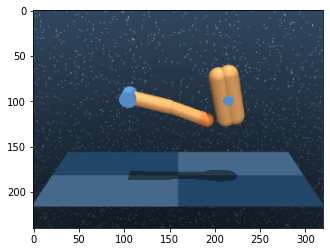

In [5]:
# flake8: noqa: F401
# type: ignore
import os
os.environ["MUJOCO_GL"] = "egl"
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

from carl.envs.dmc.carl_dm_finger import CARLDmcFingerEnv

carl_env = CARLDmcFingerEnv(
    task="spin_context",
    contexts=None,
    context_mask=[],
    hide_context=False,
    dict_observation_space=True,
)
action = carl_env.action_space.sample()
state, reward, done, info = carl_env.step(action=action)
print("state", state, type(state))

render = lambda: plt.imshow(carl_env.render(mode="rgb_array"))
s = carl_env.reset()
render()
# plt.savefig("dm_render.png")
action = carl_env.action_space.sample()
state, reward, done, info = carl_env.step(action=action)
print("state", state, type(state))


plt.show()


In [6]:
from __future__ import annotations
import sys
sys.path.append("..")

import numpy as np
from dm_control.rl import control  # type: ignore
from dm_control.suite.finger import (  # type: ignore
    _CONTROL_TIMESTEP,
    _DEFAULT_TIME_LIMIT,
    _EASY_TARGET_SIZE,
    _HARD_TARGET_SIZE,
    SUITE,
    Physics,
    Spin,
    Turn,
    get_model_and_assets,
)

from carl.envs.dmc.dmc_tasks.utils import adapt_context  # type: ignore
from carl.utils.types import Context

def spin_context(
    context: Context = {},
    context_mask: list = [],
    time_limit: float = _DEFAULT_TIME_LIMIT,
    random: np.random.RandomState | int | None = None,
    environment_kwargs: dict | None = None,
    xml_string = None
) -> control.Environment:
    """Returns the Spin task."""
    xml_string_, assets = get_model_and_assets()
    if xml_string is None:
        xml_string = xml_string_
    if context != {}:
        xml_string = adapt_context(
            xml_string=xml_string, context=context, context_mask=context_mask
        )
    physics = Physics.from_xml_string(xml_string, assets)
    task = Spin(random=random)
    environment_kwargs = environment_kwargs or {}
    return control.Environment(
        physics,
        task,
        time_limit=time_limit,
        control_timestep=_CONTROL_TIMESTEP,
        **environment_kwargs,
    )

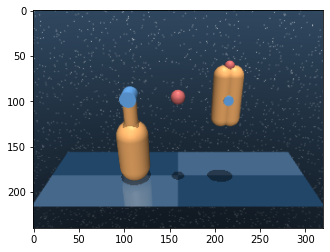

In [24]:
from carl.envs.dmc.wrappers import MujocoToGymWrapper
import matplotlib.pyplot as plt



xml_string = """
 <mujoco model="finger">
  <include file="./common/visual.xml"/>
  <include file="./common/skybox.xml"/>
  <include file="./common/materials.xml"/>

  <option timestep="0.01" cone="elliptic" iterations="200">
    <flag gravity="disable"/>
  </option>

  <default>
    <geom solimp="0 0.9 0.01" solref=".02 1"/>
    <joint type="hinge" axis="0 -1 0"/>
    <motor ctrllimited="true" ctrlrange="-1 1"/>
    <default class="finger">
      <joint damping="2.5" limited="true"/>
      <site type="ellipsoid" size=".025 .03 .025" material="site" group="3"/>
    </default>
  </default>

  <worldbody>
    <light name="light" directional="true" diffuse=".6 .6 .6" pos="0 0 2" specular=".3 .3 .3"/>
    <geom name="ground" type="plane" pos="0 0 0" size=".6 .2 10" material="grid"/>
    <camera name="cam0" pos="0 -1 .8" xyaxes="1 0 0 0 1 2"/>
    <camera name="cam1" pos="0 -1 .4" xyaxes="1 0 0 0 0 1" />

    <body name="proximal" pos="-.2 0 .4" childclass="finger">
      <geom name="proximal_decoration" type="cylinder" fromto="0 -.033 0 0 .033 0" size=".034" material="decoration"/>
      <joint name="proximal" range="-110 110" ref="-90"/>
      <geom name="proximal" type="capsule" material="self" size=".03" fromto="0 0 0 0 0 -.17"/>
      <body name="distal" pos="0 0 -.18" childclass="finger">
        <joint name="distal" range="-110 110"/>
        <geom name="distal" type="capsule" size=".028" material="self" fromto="0 0 0 0 0 -.16" contype="0" conaffinity="0"/>
        <geom name="fingertip" type="capsule" size=".03" material="effector" fromto="0 0 -.13 0 0 -.161"/>
        <site name="touchtop" pos=".01 0 -.17"/>
        <site name="touchbottom" pos="-.01 0 -.17"/>
      </body>
    </body>

    <body name="spinner" pos=".2 0 .4">
      <joint name="hinge" frictionloss=".1" damping=".5"/>
      <geom name="cap1" type="capsule" size=".04 .09" material="self" pos=".02 0 0"/>
      <geom name="cap2" type="capsule" size=".04 .09" material="self" pos="-.02 0 0"/>
      <site name="tip" type="sphere"  size=".02" pos="0 0 .13" material="target"/>
      <geom name="spinner_decoration" type="cylinder" fromto="0 -.045 0 0 .045 0" size=".02" material="decoration"/>
    </body>

    <site name="target" type="sphere" size=".03" pos="0 0 .4" material="target"/>
  </worldbody>

  <actuator>
    <motor name="proximal" joint="proximal" gear="30"/>
    <motor name="distal" joint="distal" gear="15"/>
  </actuator>

  <!-- All finger observations are functions of sensors. This is useful for finite-differencing. -->
  <sensor>
    <jointpos name="proximal" joint="proximal"/>
    <jointpos name="distal" joint="distal"/>
    <jointvel name="proximal_velocity" joint="proximal"/>
    <jointvel name="distal_velocity" joint="distal"/>
    <jointvel name="hinge_velocity" joint="hinge"/>
    <framepos name="tip" objtype="site" objname="tip"/>
    <framepos name="target" objtype="site" objname="target"/>
    <framepos name="spinner" objtype="xbody" objname="spinner"/>
    <touch name="touchtop" site="touchtop"/>
    <touch name="touchbottom" site="touchbottom"/>
    <framepos name="touchtop_pos" objtype="site" objname="touchtop"/>
    <framepos name="touchbottom_pos" objtype="site" objname="touchbottom"/>
  </sensor>

</mujoco>

"""


env = spin_context(xml_string=xml_string)
env = MujocoToGymWrapper(env)
img = env.render(mode="rgb_array")
plt.imshow(img)
plt.show()